#3

(a)

In [1]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,mean_squared_error
import matplotlib.pyplot as plt

# Load the training and test datasets
train_data = pd.read_csv("Variable Importance Data/train.csv")
test_data = pd.read_csv("Variable Importance Data/test.csv")
name=train_data.columns
# Extract the features (X1 to X5) and the target (Y)
X_train = train_data[['X1', 'X2', 'X3', 'X4', 'X5']].to_numpy()
y_train = train_data['Y'].to_numpy()
X_test = test_data[['X1', 'X2', 'X3', 'X4', 'X5']].to_numpy()
y_test = test_data['Y'].to_numpy()

def find_best_surrogate_split(X, y, s_t, features):
    L = X[:, s_t] == 0
    R = X[:, s_t] == 1
    P_L = L.sum()/ len(X)
    P_R = R.sum()/ len(X)
    
    result = -1
    lamda = float('-inf')
    for j in features:
        if j != s_t:
            Ljt = X[:, j] == 0
            Rjt = X[:, j] == 1    
            P_LL = np.logical_and(L, Ljt).sum()/len(X)
            P_RR = np.logical_and(R, Rjt).sum()/len(X)
            if (min(P_L, P_R)-(1-P_LL-P_RR))/min(P_L, P_R)>lamda:
                lamda=(min(P_L, P_R)-(1-P_LL-P_RR))/min(P_L, P_R)
                result=j
    return result

(i)

decision stump based on the best split:


[Text(0.5, 0.75, 'X1 <= 0.5\ngini = 0.499\nsamples = 500\nvalue = [241, 259]'),
 Text(0.25, 0.25, 'gini = 0.241\nsamples = 243\nvalue = [209, 34]'),
 Text(0.75, 0.25, 'gini = 0.218\nsamples = 257\nvalue = [32, 225]')]

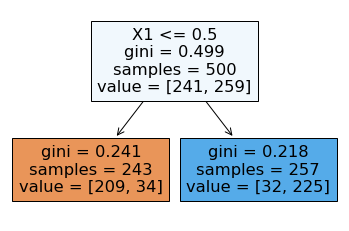

In [2]:
tree_best_split = DecisionTreeClassifier(max_depth=1, criterion='gini')
tree_best_split.fit(X_train, y_train)

surrogate_index = find_best_surrogate_split(X_train, y_train, tree_best_split.tree_.feature[0],range(X_train.shape[1]))
tree_best_surrogate = DecisionTreeClassifier(max_depth=1, criterion='gini')
tree_best_surrogate.fit(X_train[:, surrogate_index].reshape(-1, 1), y_train)
print('decision stump based on the best split:')
plot_tree(tree_best_split,feature_names=name,filled=True)

decision stump based on the best surrogate split:


[Text(0.5, 0.75, 'X2 <= 0.5\ngini = 0.499\nsamples = 500\nvalue = [241, 259]'),
 Text(0.25, 0.25, 'gini = 0.407\nsamples = 246\nvalue = [176, 70]'),
 Text(0.75, 0.25, 'gini = 0.381\nsamples = 254\nvalue = [65, 189]')]

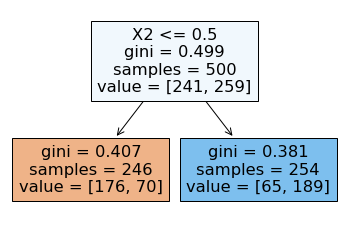

In [3]:
print('decision stump based on the best surrogate split:')
plot_tree(tree_best_surrogate,feature_names=['X'+str(surrogate_index+1)],filled=True)

(ii)

In [4]:
variable_importances_2 = tree_best_split.tree_.compute_feature_importances(normalize=False)
variable_importances_3 = tree_best_split.tree_.compute_feature_importances(normalize=False)
variable_importances_3[surrogate_index]+=tree_best_surrogate.tree_.compute_feature_importances(normalize=False)[0]
print('variable importance measurements from Equations (2):')
print('[X1 ,X2, X3, X4, X5]:',variable_importances_2)
print('variable importance measurements from Equations (3):')
print('[X1, X2, X3, X4, X5]:',variable_importances_3)

variable importance measurements from Equations (2):
[X1 ,X2, X3, X4, X5]: [0.27031855 0.         0.         0.         0.        ]
variable importance measurements from Equations (3):
[X1, X2, X3, X4, X5]: [0.27031855 0.10556223 0.         0.         0.        ]


Equations 3 suggestes that X1 and X2 are more important than others, and X1 is the most important while X2 is the second most important. Equations 2 only shows the importance of X1 while the importance of X2 is hidden.

(iii)

In [5]:
y_pred_best_split = tree_best_split.predict(X_test)
y_pred_best_surrogate = tree_best_surrogate.predict(X_test[:, surrogate_index].reshape(-1, 1))

error_best_split = 1 - accuracy_score(y_test, y_pred_best_split)
error_best_surrogate = 1 - accuracy_score(y_test, y_pred_best_surrogate)

print("Mean Misclassification Error (Best Split):", error_best_split)
print("Mean Misclassification Error (Best Surrogate Split):", error_best_surrogate)

Mean Misclassification Error (Best Split): 0.09999999999999998
Mean Misclassification Error (Best Surrogate Split): 0.27


(b)

In [6]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.utils import resample
import pandas as pd

M = 1000 
n = len(X_train)
K_values = [1, 2, 3, 4, 5] 

results_dfs = []
feature_importance_best_split_dict_1 = {}
feature_importance_best_split_dict_2 = {}
misclassification_errors_majority_vote = []
misclassification_errors_individual_stumps = []

for K in K_values:
    rows = []
    feature_importance_best_split_1 = np.zeros(X_train.shape[1])
    feature_importance_best_split_2 = np.zeros(X_train.shape[1])
    feature_selection_counts = np.zeros(X_train.shape[1])
    stump_predictions = []
    for m in range(M):
        bootstrap_indices = resample(range(n), n_samples=int(0.8 * n))
        X_bootstrap = X_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]
        
        selected_features = np.random.choice(range(X_train.shape[1]), K, replace=False)
        X_bootstrap_selected = X_bootstrap[:, selected_features]
        clf = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=42)
        clf.fit(X_bootstrap_selected, y_bootstrap)
        
        best_split_variable = selected_features[clf.tree_.feature[0]]
        best_surrogate_variable = find_best_surrogate_split(X_bootstrap, y_bootstrap, best_split_variable,selected_features)
        if best_split_variable != -1:
            rows.append({'K': K, 'Variable': 'X'+str(best_split_variable+1), 'Best Split Count': 1, 'Best Surrogate Count': 0})
        if best_surrogate_variable!=-1:
            rows.append({'K': K, 'Variable': 'X'+str(best_surrogate_variable+1), 'Best Split Count': 0, 'Best Surrogate Count': 1})
        
        importance_best_split = clf.tree_.compute_feature_importances(normalize=False)
        feature_importance_best_split_1[selected_features] += importance_best_split
        feature_selection_counts[best_split_variable] += 1
        
        OOB_idx = np.where((np.isin(np.arange(X_train.shape[0]), bootstrap_indices) == False))
        X_OOB = X_train[OOB_idx]
        y_OOB = y_train[OOB_idx]
        X_OOB_selected = X_OOB[:, selected_features]
        original_predictions = clf.predict(X_OOB_selected)
        original_oob_error = mean_squared_error(y_OOB, original_predictions)

        X_permuted = np.random.permutation(X_OOB[:, selected_features])
        permuted_predictions = clf.predict(X_permuted)
        permuted_oob_error = mean_squared_error(y_OOB, permuted_predictions)
        difference = permuted_oob_error-original_oob_error
        feature_importance_best_split_2[best_split_variable] += difference
        
        predictions = clf.predict(X_test[:, selected_features])
        stump_predictions.append(predictions)

    results_dfs.append(pd.DataFrame(rows))
    feature_importance_best_split_dict_1[K] = feature_importance_best_split_1/feature_selection_counts
    feature_importance_best_split_dict_2[K] = feature_importance_best_split_2/feature_selection_counts
    
    majority_vote_predictions = np.round(np.mean(stump_predictions, axis=0))
    misclassification_error_majority_vote = 1 - accuracy_score(y_test, majority_vote_predictions)
    misclassification_errors_majority_vote.append(misclassification_error_majority_vote)
    
    individual_stump_errors = [1 - accuracy_score(y_test, predictions) for predictions in stump_predictions]
    misclassification_error_individual_stumps = np.mean(individual_stump_errors)
    misclassification_errors_individual_stumps.append(misclassification_error_individual_stumps)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_40148\731650558.py:61: RuntimeWarning: invalid value encountered in divide
  feature_importance_best_split_dict_1[K] = feature_importance_best_split_1/feature_selection_counts
C:\Users\lenovo\AppData\Local\Temp\ipykernel_40148\731650558.py:62: RuntimeWarning: invalid value encountered in divide
  feature_importance_best_split_dict_2[K] = feature_importance_best_split_2/feature_selection_counts
C:\Users\lenovo\AppData\Local\Temp\ipykernel_40148\731650558.py:61: RuntimeWarning: invalid value encountered in divide
  feature_importance_best_split_dict_1[K] = feature_importance_best_split_1/feature_selection_counts
C:\Users\lenovo\AppData\Local\Temp\ipykernel_40148\731650558.py:62: RuntimeWarning: invalid value encountered in divide
  feature_importance_best_split_dict_2[K] = feature_importance_best_split_2/feature_selection_counts


(i)

In [7]:
final_results = pd.concat(results_dfs, ignore_index=True)
final_results = final_results.groupby(['K', 'Variable']).sum().reset_index()
print(final_results.to_string(index=False))

 K Variable  Best Split Count  Best Surrogate Count
 1       X1               204                     0
 1       X2               194                     0
 1       X3               196                     0
 1       X4               222                     0
 1       X5               184                     0
 2       X1               420                     0
 2       X2               258                   106
 2       X3               109                   294
 2       X4               106                   299
 2       X5               107                   301
 3       X1               592                     0
 3       X2               299                   312
 3       X3                51                   235
 3       X4                37                   201
 3       X5                21                   252
 4       X1               777                     0
 4       X2               223                   593
 4       X3                 0                   140
 4       X4 

X1 appears as most often in best split while X2 in appears as most often in best surrogate split, so X1 and X2 are more important than others, and X1 is the most important because as long as it is selected it is the best split. When K = 1, we can only randomly select a varible as best split and there is no best surrogate split, so each variable has a similar number of times in best split and no times in best surrogate split. When K = 4, at least one of X1 and X2 will be selected, so the other variables will not be used as the best split. When K=5, all variables will be selected so the best split will only be X1, the best surrogate split will only be X2.

(ii)

In [8]:
print('variable importance measurements from Equations (5):')
summary_df_1 = pd.DataFrame({
    'K': K_values,
    '[X1 ,X2, X3, X4, X5]': [importance for importance in feature_importance_best_split_dict_1.values()]
})
print(summary_df_1.to_string(index=False))
print('variable importance measurements from Equations (6):')
summary_df_2 = pd.DataFrame({
    'K': K_values,
    '[X1 ,X2, X3, X4, X5]': [importance for importance in feature_importance_best_split_dict_2.values()]
})
print(summary_df_2.to_string(index=False))

variable importance measurements from Equations (5):
 K                                                                                            [X1 ,X2, X3, X4, X5]
 1  [0.2725241069141758, 0.10403681904887402, 0.0018360239341439996, 0.0018580884115448626, 0.0012740738686739376]
 2 [0.26901300953492085, 0.10468493743142744, 0.0033618465481037286, 0.0031069937669673865, 0.0023027704197893743]
 3    [0.2711417168648958, 0.10529095939579101, 0.003720797902912158, 0.004228145535868219, 0.0030309860876187554]
 4                                                       [0.26895186249380787, 0.10590170917399264, nan, nan, nan]
 5                                                                       [0.27160581184167326, nan, nan, nan, nan]
variable importance measurements from Equations (6):
 K                                                                                            [X1 ,X2, X3, X4, X5]
 1 [0.3659018048851496, 0.22947151272473093, -0.0069747840892785615, -0.00381081858081846

This suggest X1 and X2 are more important than the others because the importance of other variables is always close to 0. When K > 3, at least one of X1 and X2 will be selected, in which case the other variables have no importance scores. X1 is more important than X2 because the importance scores of X1 is always greater than that of X2, and when all the variables are selected, only X1 has importance scores.

Yes, masking hide the importance of some variables When using Equations (5) and (6) to compute variable importance for random forests. This is because only the selected variables will have importance scores, for example, when K = 5, only X1 has an importance score, while the importance of X2 is hidden.

In [9]:
for K, err_majority, err_individual in zip(K_values, misclassification_errors_majority_vote, \
                                           misclassification_errors_individual_stumps):
    print(f"K = {K}:")
    print(f"Mean Misclassification Error (Majority Vote): {err_majority:.4f}")
    print(f"Mean Misclassification Error (Individual Stumps): {err_individual:.4f}")
    print()


K = 1:
Mean Misclassification Error (Majority Vote): 0.1400
Mean Misclassification Error (Individual Stumps): 0.3766

K = 2:
Mean Misclassification Error (Majority Vote): 0.1100
Mean Misclassification Error (Individual Stumps): 0.2718

K = 3:
Mean Misclassification Error (Majority Vote): 0.1000
Mean Misclassification Error (Individual Stumps): 0.1936

K = 4:
Mean Misclassification Error (Majority Vote): 0.1000
Mean Misclassification Error (Individual Stumps): 0.1379

K = 5:
Mean Misclassification Error (Majority Vote): 0.1000
Mean Misclassification Error (Individual Stumps): 0.1000



The first method is correct for computing the prediction error of the random forest. Because the final prediction of a random forest is made by majority voting on the predictions of the individual trees, the majority vote and the subsequently calculated mean classification error represent the performance of the random forest. The second method is not the correct way to compute the prediction error of a random forest. It essentially treats the random forest as a simple average or weighted average of individual stumps, neglecting the ensembling aspect that makes random forests powerful.

(c) 

In [10]:
q_values = [0.4, 0.5, 0.6, 0.7, 0.8]


feature_importance_best_split_dict_1 = {}
feature_importance_best_split_dict_2 = {}

for q in q_values:    
    feature_importance_best_split_1 = np.zeros(X_train.shape[1])
    feature_importance_best_split_2 = np.zeros(X_train.shape[1])
    feature_selection_counts = np.zeros(X_train.shape[1])
    B=int(q * n)
    for m in range(M):
        bootstrap_indices = resample(range(n), n_samples=B)
        X_bootstrap = X_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]
        
        selected_features = np.random.choice(range(X_train.shape[1]), 2, replace=False)
        X_bootstrap_selected = X_bootstrap[:, selected_features]
        clf = DecisionTreeClassifier(criterion='gini', max_depth=1, random_state=42)
        clf.fit(X_bootstrap_selected, y_bootstrap)
        
        best_split_variable = selected_features[clf.tree_.feature[0]]
        best_surrogate_variable = find_best_surrogate_split(X_bootstrap, y_bootstrap, best_split_variable,selected_features)
        
        importance_best_split = clf.tree_.compute_feature_importances(normalize=False)
        feature_importance_best_split_1[selected_features] += importance_best_split
        feature_selection_counts[best_split_variable] += 1
        
        OOB_idx = np.where((np.isin(np.arange(X_train.shape[0]), bootstrap_indices) == False))
        X_OOB = X_train[OOB_idx]
        y_OOB = y_train[OOB_idx]
        X_OOB_selected = X_OOB[:, selected_features]
        original_predictions = clf.predict(X_OOB_selected)
        original_oob_error = mean_squared_error(y_OOB, original_predictions)

        X_permuted = np.random.permutation(X_OOB[:, selected_features])
        permuted_predictions = clf.predict(X_permuted)
        permuted_oob_error = mean_squared_error(y_OOB, permuted_predictions)
        difference = permuted_oob_error-original_oob_error
        feature_importance_best_split_2[best_split_variable] += difference

    results_dfs.append(pd.DataFrame(rows))
    feature_importance_best_split_dict_1[B] = feature_importance_best_split_1/feature_selection_counts
    feature_importance_best_split_dict_2[B] = feature_importance_best_split_2/feature_selection_counts

(i)

In [11]:
print('variable importance measurements from Equations (5):')
summary_df_1 = pd.DataFrame({
    'q': q_values,
    '[X1 ,X2, X3, X4, X5]': [importance for importance in feature_importance_best_split_dict_1.values()]
})

# pd.set_option('display.max_colwidth', None)
print(summary_df_1.to_string(index=False))
print('variable importance measurements from Equations (6):')
summary_df_2 = pd.DataFrame({
    'q': q_values,
    '[X1 ,X2, X3, X4, X5]': [importance for importance in feature_importance_best_split_dict_2.values()]
})
# pd.set_option('display.max_colwidth', None)
print(summary_df_2.to_string(index=False))

variable importance measurements from Equations (5):
  q                                                                                           [X1 ,X2, X3, X4, X5]
0.4     [0.2699584502257445, 0.10517827376197325, 0.005351877232110975, 0.003475133436478986, 0.00470998234499335]
0.5   [0.2709941430825501, 0.10576009090056726, 0.003801964324824303, 0.0038219312443690196, 0.003035750979615089]
0.6  [0.2696378366509234, 0.10751048938529446, 0.003760443678218552, 0.0038547215975431436, 0.0030344346631102103]
0.7 [0.27143890969683127, 0.10584647856381839, 0.0035049415954947634, 0.002853927124429938, 0.0029586392664012035]
0.8   [0.2712527203605367, 0.10738426574098335, 0.002632120374125821, 0.003411509200048912, 0.0019332661741783361]
variable importance measurements from Equations (6):
  q                                                                                             [X1 ,X2, X3, X4, X5]
0.4    [0.3677943939450632, 0.2303534519904696, -0.004596570896593222, -0.0047995228981

This suggest X1 and X2 are more important than the others because the importance of other variables is always close to 0. X1 is more important because it has greater importance score than X2. This result does not depend on B because it is similar for all q.

#4

Training Accuracy: 0.989010989010989.
Test Accuracy: 1.0.


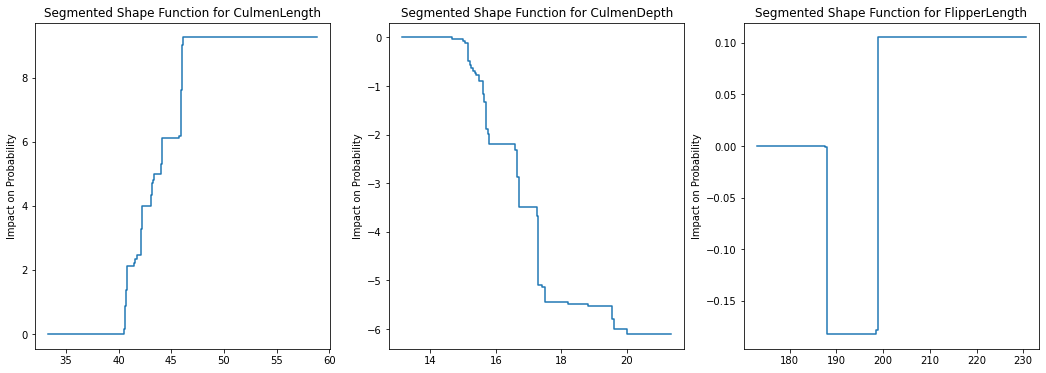

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('./penguins_trunc.csv')
X = data.drop('Species', axis=1).to_numpy()
y = data['Species'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
thresholds = np.zeros([X_train.shape[0]-1, X_train.shape[1]])

for i in range(X_train.shape[1]):
    sorted_feature_i = np.sort(X_train[:, i])
    for j in range(X_train.shape[0] - 1):
        thresholds[j, i] = ((sorted_feature_i[j + 1] + sorted_feature_i[j]) / 2)
        
def binarize_features(data, thresholds):
    binary_features = []
    for i in range(data.shape[1]):
        for j, thr in enumerate(thresholds[:, i]):
            binary_features.append((data[:, i] > thr).astype(int))
    return np.array(binary_features).T
        
binary_features_train = binarize_features(X_train, thresholds)
binary_features_test = binarize_features(X_test, thresholds)        

model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(binary_features_train, y_train)

train_accuracy = model.score(binary_features_train, y_train)
test_accuracy = model.score(binary_features_test, y_test)

print(f'Training Accuracy: {train_accuracy}.')
print(f'Test Accuracy: {test_accuracy}.')

feature_names = list(data.drop('Species', axis=1).columns)

weights = model.coef_[0]
fig, ax = plt.subplots(1, X_train.shape[1], figsize=(18, 6))

for i in range(X_train.shape[1]):
    feature_weights = weights[i * (X_train.shape[0] - 1):(i + 1) * (X_train.shape[0] - 1)]
    cumulative_weights = np.cumsum(feature_weights) 
    ax[i].step(thresholds[:, i], cumulative_weights)
    ax[i].set_title(f"Segmented Shape Function for {feature_names[i]}")
    ax[i].set_ylabel("Impact on Probability")
plt.show()

#5

(a)

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('Titanic.csv')

df = df.drop(['Age', 'Cabin', 'Embarked'], axis = 1)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

X = df.drop('Survived', axis=1) 
y = df['Survived'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

(b)

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

ada_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
xgb_classifier = XGBClassifier()

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

grid_search_ada = GridSearchCV(ada_classifier, param_grid_ada, cv=5)
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, cv=5)

grid_search_ada.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)

y_pred_ada = grid_search_ada.predict(X_test)
y_pred_xgb = grid_search_xgb.predict(X_test)

print("Performance Metrics for Adaboost:")
print(classification_report(y_test, y_pred_ada))
print("Accuracy:", accuracy_score(y_test, y_pred_ada))

print("\nPerformance Metrics for XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

Performance Metrics for Adaboost:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       110
           1       0.71      0.72      0.72        69

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Accuracy: 0.7821229050279329

Performance Metrics for XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       110
           1       0.75      0.68      0.71        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179

Accuracy: 0.7877094972067039


Both models perform similarly on these metrics, which may be because the dataset is not large enough to show their differences